## Import Library

In [3]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.1 MB/s eta 0:00:00


## Illustrate

### 1. Named Entity Recognition

In [2]:
from underthesea import ner
text = 'Chưa tiết lộ lịch trình tới Việt Nam của Tổng thống Mỹ Donald Trump'
ner(text)

[('Chưa', 'R', 'O', 'O'),
 ('tiết lộ', 'V', 'B-VP', 'O'),
 ('lịch trình', 'V', 'B-VP', 'O'),
 ('tới', 'E', 'B-PP', 'O'),
 ('Việt Nam', 'Np', 'B-NP', 'B-LOC'),
 ('của', 'E', 'B-PP', 'O'),
 ('Tổng thống', 'N', 'B-NP', 'O'),
 ('Mỹ', 'Np', 'B-NP', 'B-LOC'),
 ('Donald', 'Np', 'B-NP', 'B-PER'),
 ('Trump', 'Np', 'B-NP', 'I-PER')]

In [3]:
sentence = "Ông Putin ca ngợi những thành tựu vĩ đại của Liên Xô"
ner(sentence)

[('Ông', 'Nc', 'B-NP', 'O'),
 ('Putin', 'Np', 'B-NP', 'B-PER'),
 ('ca ngợi', 'V', 'B-VP', 'O'),
 ('những', 'L', 'B-NP', 'O'),
 ('thành tựu', 'N', 'B-NP', 'O'),
 ('vĩ đại', 'A', 'B-AP', 'O'),
 ('của', 'E', 'B-PP', 'O'),
 ('Liên Xô', 'Np', 'B-NP', 'B-LOC')]

### 2. Sentiment

In [8]:
from underthesea import sentiment
sentence = "Vừa smartbidv, vừa bidv online mà lại k dùng chung 1 tài khoản đăng nhập, rắc rối!"
print(sentiment(sentence, domain='bank'))

['INTERNET_BANKING#negative']


In [28]:
from underthesea import sentiment
sentence = "Ngân hàng này tốt quá"
print(sentiment(sentence))

positive


## Text Classification

In [4]:
# === Libraries ===
import re
import string
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from underthesea import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [4]:
# === Download dataset ===
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tuannguyenvananh/vietnamese-text-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vietnamese-text-classification-dataset


In [5]:
data = pd.read_csv('/kaggle/input/vietnamese-text-classification-dataset/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   0                       3039 non-null   int64 
 1   máy dùng hay bị đơ máy  3039 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


In [6]:
data.columns = ['labels', 'text']

In [38]:
data.head()

,labels,text
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...
1,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
2,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
3,2,Tuyệt vời. Hàng FPT cửa hàng
4,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...


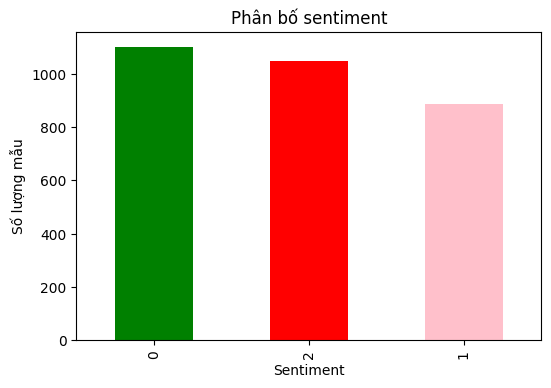

In [39]:
# Check the labels 
plt.figure(figsize=(6,4))
data["labels"].value_counts().plot(kind="bar", color=["green","red","pink"])
plt.title("Phân bố sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.show()

### Text Preprocessing

In [7]:
# === Text preprocessing for Vietnamese ===
def clean_text_vi(text: str) -> str:
    """ Lowercase, remove URLs, tokenize Vietnamese words, strip punctuation; 
        return a clean string."""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    tokens = word_tokenize(text)   
    out = []
    for tok in tokens:
        for sub in tok.split():  
            if sub not in string.punctuation:
                out.append(sub)
    return " ".join(out)

### Logistic regression

In [8]:
# === Vietnamese tokenizer with TF-IDF ===
def uts_tokenize(s: str):
    return word_tokenize(s, format="text").split()
X, y = data["text"].astype(str), data["labels"].astype(str)

# === Train/test split with stratify ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Build pipeline: TF-IDF + Logistic Regression ===
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=clean_text_vi,   
        ngram_range=(1,3),
        min_df=2, max_df=0.8
    )),
    
    ("clf", LogisticRegression(
        max_iter=1000,              
        n_jobs=None,                
        class_weight=None           
    ))
])

# === Train ===
pipe.fit(X_train, y_train)

# === Evaluate ===
pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print("F1-macro:", f1_score(y_test, pred, average="macro"))
print(classification_report(y_test, pred))

Accuracy: 0.7861842105263158
F1-macro: 0.7727185686531808
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       221
           1       0.68      0.58      0.63       177
           2       0.87      0.86      0.87       210

    accuracy                           0.79       608
   macro avg       0.78      0.77      0.77       608
weighted avg       0.78      0.79      0.78       608



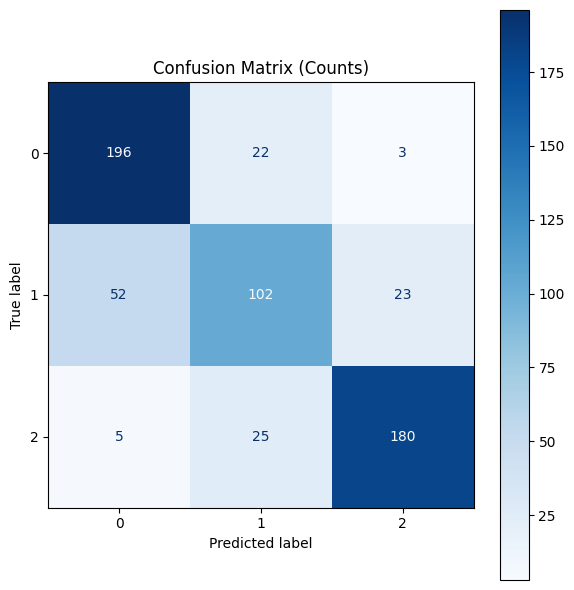

In [10]:
labels = pipe.named_steps["clf"].classes_

# Counts
cm = confusion_matrix(y_test, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=True)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()